In [1]:
from threading import Thread
import cv2
import IPython
import numpy as np
import os
import shutil
import time
from pynq import GPIO
import smbus  # Must sudo apt install python3-smbus !

refresh_flag = 0

class User:
    def __init__(self, name, faces, count):
        self.name = name
        self.faces = faces
        self.count = count
    
    def incrementCount(self):
        self.count += 1
        if self.count > 5:
            self.count = 1
        print("%s %d" % (self.name, self.count))            
        return self.count
 
    def setFaces(self, face):
        self.faces.append(face)
        
    def getFaces(self):
        return self.faces
    
    def getName(self):
        return self.name
    
class WebcamVideoStream:
    def __init__(self, src=0, width = 1280, height = 960, name="WebcamVideoStream"):
        # initialize the video camera stream and read the first frame
        # from the stream
        self.stream = cv2.VideoCapture(src)

        self.stream.set(cv2.CAP_PROP_FRAME_WIDTH,width)
        self.stream.set(cv2.CAP_PROP_FRAME_HEIGHT,height)
        
        (self.grabbed, self.frame) = self.stream.read()

        # initialize the thread name
        self.name = name

        # initialize the variable used to indicate if the thread should
        # be stopped
        self.stopped = False

    def start(self):
        # start the thread to read frames from the video stream
        t = Thread(target=self.update, name=self.name, args=())
        t.daemon = True
        t.start()
        return self

    def update(self):
        # keep looping infinitely until the thread is stopped
        while True:
            # if the thread indicator variable is set, stop the thread
            if self.stopped:
                return

            # otherwise, read the next frame from the stream
            (self.grabbed, self.frame) = self.stream.read()

    def read(self):
        # return the frame most recently read
        return self.frame

    def stop(self):
        # indicate that the thread should be stopped
        self.stopped = True 
        
    def end(self):
        self.stream.release()
        # release the camera

def imshow(img):
    returnValue, buffer = cv2.imencode('.jpg',img)
    IPython.display.display(IPython.display.Image(data=buffer.tobytes()))

def imwrite(img, name):
    returnValue, buffer = cv2.imencode('.jpg',img)
    cv2.imwrite(name,buffer)
    
def poll_for_face(video):
    haar_face_cascade = cv2.CascadeClassifier('/home/xilinx/opencv/data/haarcascades/haarcascade_frontalface_default.xml')
    while True:
        frame_in = video.read()
        face_frame = np.copy(frame_in)
        faces = haar_face_cascade.detectMultiScale(face_frame[:,:,1], scaleFactor=1.1, minSize=(4,4), minNeighbors=6)
        IPython.display.clear_output(wait=True)
        imshow(face_frame)
        IPython.display.clear_output(wait=True)
        cv2.imwrite("LastHour/%s.jpg" % time.ctime(time.time()-25200), face_frame)
        if refresh_flag == 1:
            LH_list = os.listdir("LastHour")
            LH_list.sort()
            os.remove("LastHour/%s" % LH_list[1])
        if len(faces) != 0:
            cv2.putText(face_frame, "FACE DETECTED",(10,25), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,0), 2)
            for (x,y,w,h) in faces:
                cv2.rectangle(face_frame, (x,y), (x+w,y+h), (0,0,0), 3)
            imshow(face_frame)
            return face_frame, faces
            break
            
def show_face(face_frame, faces):
    haar_face_cascade = cv2.CascadeClassifier('/home/xilinx/opencv/data/haarcascades/haarcascade_frontalface_default.xml')
    #for (x,y,w,h) in faces:
        #cv2.rectangle(face_frame, (x,y), (x+w,y+h), (0,0,0), 3)
    cv2.putText(face_frame, "FACE DETECTED",(10,25), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,0), 2)
    imshow(face_frame)
    
    
def classify_face(face_frame, faces):
    facenet = cv2.dnn.readNetFromCaffe('bvlc_googlenet.prototxt', 'bvlc_googlenet.caffemodel')
    face_crop = face_frame[faces[0][1]:faces[0][1] + faces[0][3], faces[0][0]:faces[0][0] + faces[0][2], :]
    faceblob = cv2.dnn.blobFromImage(face_crop, 1, (224, 224))
    facenet.setInput(faceblob)
    facenet_fingerprint = facenet.forward()
    return facenet_fingerprint

def add(person, known_users):
    try:
        os.mkdir("KnownUsers/%s" % person.getName())
    except FileExistsError:
        pass
    inc = 0
    haar_face_cascade = cv2.CascadeClassifier('/home/xilinx/opencv/data/haarcascades/haarcascade_frontalface_default.xml')
    instances = int(input("Please enter the amount of instances of %s's face: " % person.getName()), 10)
    while inc < instances:
        frame_in = video.read()
        face_frame = np.copy(frame_in)
        faces = haar_face_cascade.detectMultiScale(face_frame[:,:,1], scaleFactor=1.1, minSize=(4,4), minNeighbors=6)
        if len(faces) != 0:
            print("%d. %s's face detected" % (inc+1, person.getName()))
            inc += 1
            facenet = cv2.dnn.readNetFromCaffe('bvlc_googlenet.prototxt', 'bvlc_googlenet.caffemodel')
            face_crop = face_frame[faces[0][1]:faces[0][1] + faces[0][3], faces[0][0]:faces[0][0] + faces[0][2], :]
            faceblob = cv2.dnn.blobFromImage(face_crop, 1, (224, 224))
            facenet.setInput(faceblob)
            facenet_fingerprint = facenet.forward()
            person.setFaces(facenet_fingerprint)
            cv2.imwrite("KnownUsers/%s/%s_%d.jpg" % (person.getName(), person.getName(), inc), face_frame)
            if inc >= 10:
                print("    Instance added")
            else:
                print("   Instance added")
        else:
            print("Please show %s's face." % person.getName())
    known_users.append(person)
    print("%s added" % person.getName())
    
def delete(person, known_users):
    try:
        shutil.rmtree("KnownUsers/%s" % person.getName())
    except (NameError, FileNotFoundError):
        print("%s is not a known user" % person)
        return
    for user in known_users:
        if person == user:
            known_users.remove(person)

def init_directories():
    try:
        shutil.rmtree("Entrants")
    except FileNotFoundError:
        pass
    try:
        shutil.rmtree("KnownUsers")
    except FileNotFoundError:
        pass
    try:
        shutil.rmtree("NonUsers")
    except FileNotFoundError:
        pass
    try:
        shutil.rmtree("LastHour")
    except FileNotFoundError:
        pass

    try:
        os.mkdir("Entrants")
    except FileExistsError:
        pass
    try:
        os.mkdir("KnownUsers")
    except FileExistsError:
        pass
    try:
        os.mkdir("NonUsers")
    except FileExistsError:
        pass
    try:
        os.mkdir("LastHour")
    except FileExistsError:
        pass
    

def i2c_read_byte(i2c, DA, DR):
    return (0xff & i2c.read_byte_data(DA, DR))

def i2c_write_byte(i2c, DA, val):
    return (i2c.write_byte(DA, val))

i2c_bus = smbus.SMBus(2)  # 2 = /dev/i2c-2, 3 = /dev/i2c-3 etc.

DA = 0b1110000  # Device Address for PWM controller is 0b1110000


def open():
    i2c_bus.write_byte_data(DA, 0x00, 0b00010001) #control reg value
    time.sleep(0.5)
    i2c_bus.write_byte_data(DA, 0xFE, 0x81) #prescale value
    time.sleep(0.5)
    i2c_bus.write_byte_data(DA, 0x00, 0b00100001) #control reg value
    time.sleep(0.5)
    i2c_bus.write_i2c_block_data(DA, 0x0A, [0x00, 0x00, 0x67, 0x00]) #LED0_ON_L
    time.sleep(0.5)

def close():
    i2c_bus.write_byte_data(DA, 0x00, 0b00010001) #control reg value
    time.sleep(0.5)
    i2c_bus.write_byte_data(DA, 0xFE, 0x81) #prescale value
    time.sleep(0.5)
    i2c_bus.write_byte_data(DA, 0x00, 0b00100001) #control reg value
    time.sleep(0.5)
    i2c_bus.write_i2c_block_data(DA, 0x0A, [0x00, 0x00, 0x19, 0x01]) #LEDs
    time.sleep(0.5)

        
known_users = []

        

In [2]:
video = WebcamVideoStream()
video.start() 

In [3]:
frame_in = []
face_frame = []
faces = []
faceblob = []
face_crop = []
cutoff = 0.15
counter = 0
start = 0

init_directories()

In [4]:
julian = User("Julian", [], 0)
add(julian, known_users)

Please enter the amount of instances of Julian's face:  50


1. Julian's face detected
   Instance added
2. Julian's face detected
   Instance added
3. Julian's face detected
   Instance added
4. Julian's face detected
   Instance added
5. Julian's face detected
   Instance added
6. Julian's face detected
   Instance added
7. Julian's face detected
   Instance added
8. Julian's face detected
   Instance added
9. Julian's face detected
   Instance added
10. Julian's face detected
    Instance added
11. Julian's face detected
    Instance added
12. Julian's face detected
    Instance added
13. Julian's face detected
    Instance added
14. Julian's face detected
    Instance added
15. Julian's face detected
    Instance added
16. Julian's face detected
    Instance added
17. Julian's face detected
    Instance added
18. Julian's face detected
    Instance added
19. Julian's face detected
    Instance added
20. Julian's face detected
    Instance added
21. Julian's face detected
    Instance added
22. Julian's face detected
    Instance added
23. Ju

In [ ]:
#delete(anna, known_users)

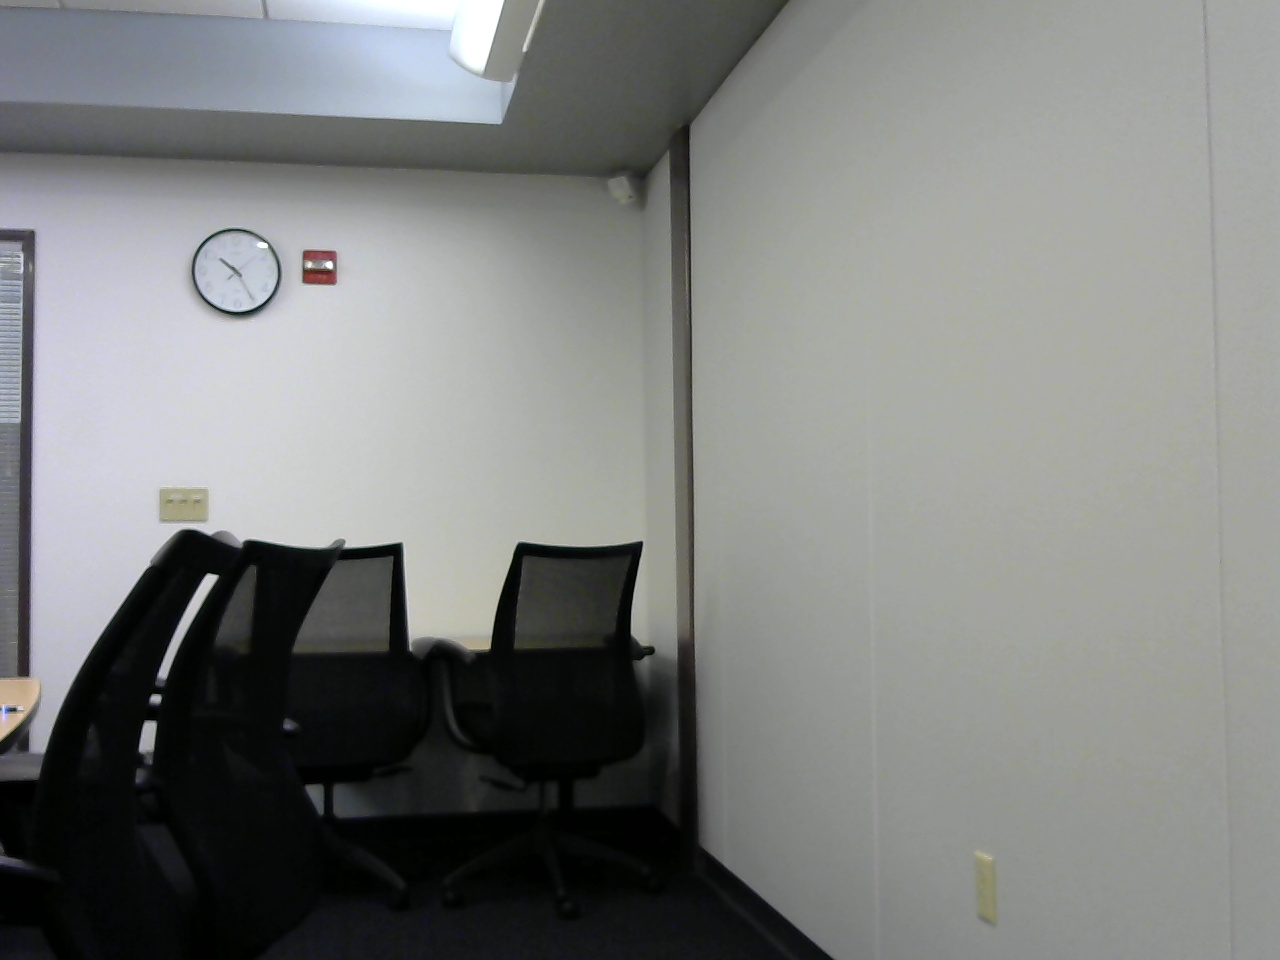

In [ ]:
start = time.time()
refresh_start = time.time()
refresh_flag = 0
close()
while True:
    refresh_end = time.time()
    end = time.time()
    postion = []
    if end - start >= 60 * 60: # 1 hour
        refresh_flag = 1
        
    if refresh_end - refresh_start >= 60 * 60: # one hour
        shutil.rmtree("Entrants")
        shutil.rmtree("NonUsers")
        os.mkdir("Entrants")
        os.mkdir("NonUsers")
        refresh_start = time.time()
        
    face_frame, faces = poll_for_face(video)
    #show_face(face_frame, faces)
    facenet_fingerprint = classify_face(face_frame, faces)
    
    for z in range(len(known_users)):
        for i,face_encodings in enumerate(known_users[z].getFaces()):
            new_flag = 0
            if np.linalg.norm(face_encodings[0] - facenet_fingerprint, axis=1) < cutoff:
                postion = [i]
                current_user = known_users[z]
                break
      
    if not postion:
        close()
        print("Door Locked")
        #cv2.putText(face_frame, time.ctime(time.time()),(10,55), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,0), 2)
        cv2.imwrite("NonUsers/NonUser: %s.jpg" % time.ctime(time.time()-25200), face_frame)

    else:
        if current_user.incrementCount() >= 5:
            open()
            print("Door Unlocked")
            cv2.putText(face_frame, "FACE DETECTED: %s" % current_user.getName(), (10,25), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,0), 2)
            #cv2.putText(face_frame, time.ctime(time.time()-25200),(10,55), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,0), 2)
            cv2.imwrite("Entrants/%s: %s.jpg" % (current_user.getName(), time.ctime(time.time()-25200)), face_frame)
            
            

In [ ]:
delete(kurt, known_users)